## Поиск точек посадки пассажиров

В этом ноутбуке реализованы различные алгоритмы для предсказания точек посадки пассажиров. Начнём с самых простых идей, затем будем их усложнять.

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap.umap_ import UMAP

from sklearn.preprocessing import StandardScaler

from sklearn.cluster import \
    KMeans, \
    AgglomerativeClustering, \
    DBSCAN, \
    SpectralClustering

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
sns.set(font_scale=1.5)

In [2]:
data = pd.read_csv('data/3k_data_features', index_col=0)

In [3]:
data.head(120)

,begin,session,status,ts,x,y,delay,dist,av_speed,x_diff,y_diff,angle
0,1,0,0,0,0.000000,0.000000,0,0.000000,NaN,0.000000,0.000000,0.000000
1,0,0,0,9,-0.644802,0.291129,9,0.707478,0.078609,-0.644802,0.291129,2.717491
2,0,0,0,17,-0.243663,1.229173,8,1.020216,0.127527,0.401139,0.938044,1.166697
3,0,0,0,25,2.447144,13.056778,8,12.129826,1.516228,2.690807,11.827605,1.347101
4,0,0,0,33,-3.184499,21.475057,8,10.128318,1.266040,-5.631643,8.418279,2.160397
...,...,...,...,...,...,...,...,...,...,...,...,...
115,1,1,0,0,0.000000,-0.000000,0,2740.430003,inf,0.000000,0.000000,0.000000
116,0,1,0,6,-0.735076,-0.143670,6,0.748985,0.124831,-0.735076,-0.143670,-2.948577
117,0,1,0,8,-0.735076,-0.143670,2,0.000000,0.000000,0.000000,0.000000,0.000000
118,0,1,0,14,-1.099865,-0.554960,6,0.549754,0.091626,-0.364788,-0.411290,-2.296347


In [4]:
data[data.session == 144].head()

,begin,session,status,ts,x,y,delay,dist,av_speed,x_diff,y_diff,angle
15868,1,144,0,0,0.0,0.0,0,370.460669,inf,0.0,0.0,0.0
15869,0,144,0,8,0.0,0.0,8,0.000000,0.0,0.0,0.0,0.0
15870,0,144,1,16,0.0,0.0,8,0.000000,0.0,0.0,0.0,0.0
15871,0,144,1,24,0.0,0.0,8,0.000000,0.0,0.0,0.0,0.0
15872,0,144,1,32,0.0,0.0,8,0.000000,0.0,0.0,0.0,0.0


## Глава 1. Наивные решения

### 1. Первая точка со статусом 2

**Идея:** водитель меняет статус, когда к нему садится пассажир.

Первое тривиальное решение, которое приходит на ум - просто брать первую точку, на которой было зафиксировано, что машина едет с пассажиром.

In [5]:
def first_status_2(data):
    d = {}
    
    session_values = np.unique(data.session.values)
    for session in tqdm_notebook(session_values):
        session_data = data[data.session == session]
        pickup_row = session_data[session_data.status == 2].head(1)
        d[session] = (pickup_row.x.values[0], pickup_row.y.values[0]) 
        
    return d

### 2. Середина отрезка между точками со статусами 1 и 2

**Идея:** водитель меняет статус с опозданием.

Так как водитель может забывать изменить статус сразу же, будем брать точку чуть раньше, а именно середину между последней точкой со статусом 1 ("подъезжает") и первой точкой со статусом 2 ("едет с пассажиром").

In [6]:
def middle_1_2(data):
    d = {}
    
    session_values = np.unique(data.session.values)
    for session in tqdm_notebook(session_values):
        session_data = data[data.session == session]
        pickup_row_1 = session_data[session_data.status == 1].tail(1)
        pickup_row_2 = session_data[session_data.status == 2].head(1)
        d[session] = ((pickup_row_1.x.values[0] + pickup_row_2.x.values[0])/2,
                      (pickup_row_1.y.values[0] + pickup_row_2.y.values[0])/2) 
        
    return d

### 3. Последняя точка со статусом 1, если точка со статусом 2 далеко

**Идея:** если водитель ставит статус "подъезжает", но следующая точка со статусом "едет с пассажиром" достаточно далеко, то скорее всего водитель забыл переключить статус вовремя, и тогда в качестве ответа будем брать последнюю точку со статусом 1, иначе первую со статусом 2.

Чтобы понять, какое расстояние считать "далёким", а какое - нет, посмотрим, как распределены расстояния при переключении статуса с 1 на 2.

In [7]:
distances = []

session_values = np.unique(data.session.values)
for session in tqdm_notebook(session_values):
    session_data = data[data.session == session]
    st2_row = session_data[session_data.status == 2].head(1)
    distances.append(st2_row.dist.values[0])
    
distances = np.array(distances)

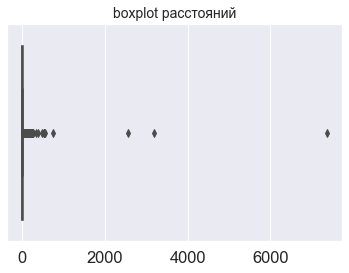

In [8]:
plt.title('boxplot расстояний',
          fontsize=14)
sns.boxplot(distances)
plt.show()

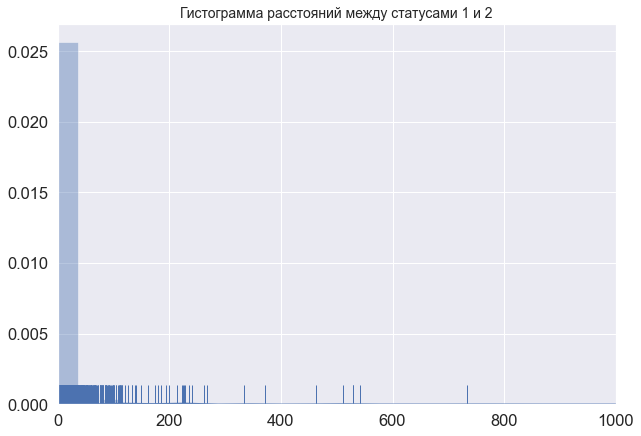

In [9]:
plt.figure(figsize=(10, 7))
plt.title('Гистограмма расстояний между статусами 1 и 2',
          fontsize=14)
sns.distplot(distances, bins=200, kde=True, rug=True)
plt.xlim(0, 1000)
plt.show()

Там где значения блихки к 0, очевидно, точка посадки - это и есть первая точка со статусом 2. Взглянем на ненулевые значения и уберем из рассмотрения чересчур большие расстояния.

In [10]:
clean_distances = distances[distances != 0.0]
clean_distances = clean_distances[clean_distances < 200]

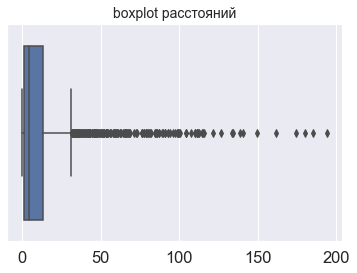

In [11]:
plt.title('boxplot расстояний',
          fontsize=14)
sns.boxplot(clean_distances)
plt.show()

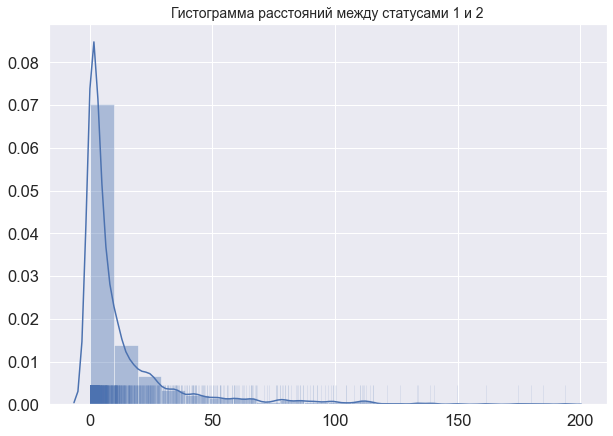

In [12]:
plt.figure(figsize=(10, 7))
plt.title('Гистограмма расстояний между статусами 1 и 2',
          fontsize=14)
sns.distplot(clean_distances, bins=20, kde=True, rug=True,
             rug_kws={'alpha': 0.1})
plt.show()

Как видим, после небольшой "чистки данных", получилось, что значения, больше 30, уже считаются выбросами. Возьмем 30 в качестве пороговой константы по умолчанию.

In [13]:
def distance_1_2(data, threshold=30):
    d = {}
    
    session_values = np.unique(data.session.values)
    for session in tqdm_notebook(session_values):
        session_data = data[data.session == session]
        st1_row = session_data[session_data.status == 1].tail(1)
        st2_row = session_data[session_data.status == 2].head(1)
        dist = st2_row.dist.values[0]
        if dist > threshold:
            d[session] = (st1_row.x.values[0],
                          st1_row.y.values[0])
        else:
            d[session] = (st2_row.x.values[0],
                          st2_row.y.values[0])
            
    return d

## Глава 2. Решения с использованием кластеризации

### 1. Поиск точек посадки с использованием алгоритмов кластеризации.

Попробуем использовать рассмотренные на лекциях алгоритмы кластеризации для улучшения предыдущих двух подходов к поиску точек посалдки.

Для кластеризации будем использовать последние две точки со статусом 0, все точки со статусом 1 и первые две точки со статусом 2.

Для кластеризации будем использовать несколько признаков - координаты, скорость и направление движения.

Будем разделять точки на три кластера. Идея заключается в том, что в реальности не все точки со статусом 1 относятся к реальному ожиданию клиента. Разделив точки на три кластера, мы разделим точки со статусом 1 на точки, в которых водитель ещё подъезжал к клиенту, точки в которых водитель реально ждал клиента и точки, в которых водитель уже ехал с клиентом. Предполоагается, что в каждой группе точки схожи по направлению движения и скорости. Чтобы кластеры были отделены друг от друга по времени, будем также использовать признак `ts(временная метка`. 

Визуализируем значала разбиение на кластеры для нескольких сессий.

KMeans:

In [14]:
def visualize_clustering(fit_predict_method, name = ''):
    session_values = np.unique(data.session.values)

    plt.figure(figsize=(20, 20))
    for i, session in tqdm_notebook(enumerate(session_values[:6])):

        session_data = data[data.session == session]
        median_dist = np.mean(session_data[session_data.status==1].dist.values)

        status_1_data = session_data[session_data.status == 1].loc[:, ['x',
                                                                       'y',
                                                                       'ts',
                                                                       'av_speed',
                                                                       'angle']].copy()
        status_0_data = session_data[session_data.status == 0].loc[:, ['x',
                                                                       'y',
                                                                       'ts',
                                                                       'av_speed',
                                                                       'angle']].copy()
        status_2_data = session_data[session_data.status == 2].loc[:, ['x',
                                                                       'y',
                                                                       'ts',
                                                                       'av_speed',
                                                                       'angle']].copy()

        status_data = pd.concat([status_0_data.iloc[-1:, :],
                                 status_1_data,
                                 status_2_data.iloc[:1, :]],
                                axis=0)

        scaler = StandardScaler(with_mean=False)
        status_data.iloc[:, :] = scaler.fit_transform(status_data.copy())
        # session_data = session_data[session_data.status != 1].loc[:, ['x', 'y']].copy()

        y_pred = fit_predict_method(status_data)

        plt.subplot(3, 3, i+1)
        plt.title(f'session {i}')
        plt.xlabel('X')
        plt.ylabel('Y')

        status_data.iloc[:, :] = scaler.inverse_transform(status_data.copy())
        plt.scatter(status_data['x'].values, status_data['y'].values,
                    c=y_pred, alpha=1, s=50, cmap='Set1')

        plt.plot(status_data['x'].values, status_data['y'].values, alpha=0.5)
    #     plt.scatter(session_data['x'].values, session_data['y'].values,
    #                  alpha=0.2, s=25)

    plt.tight_layout()

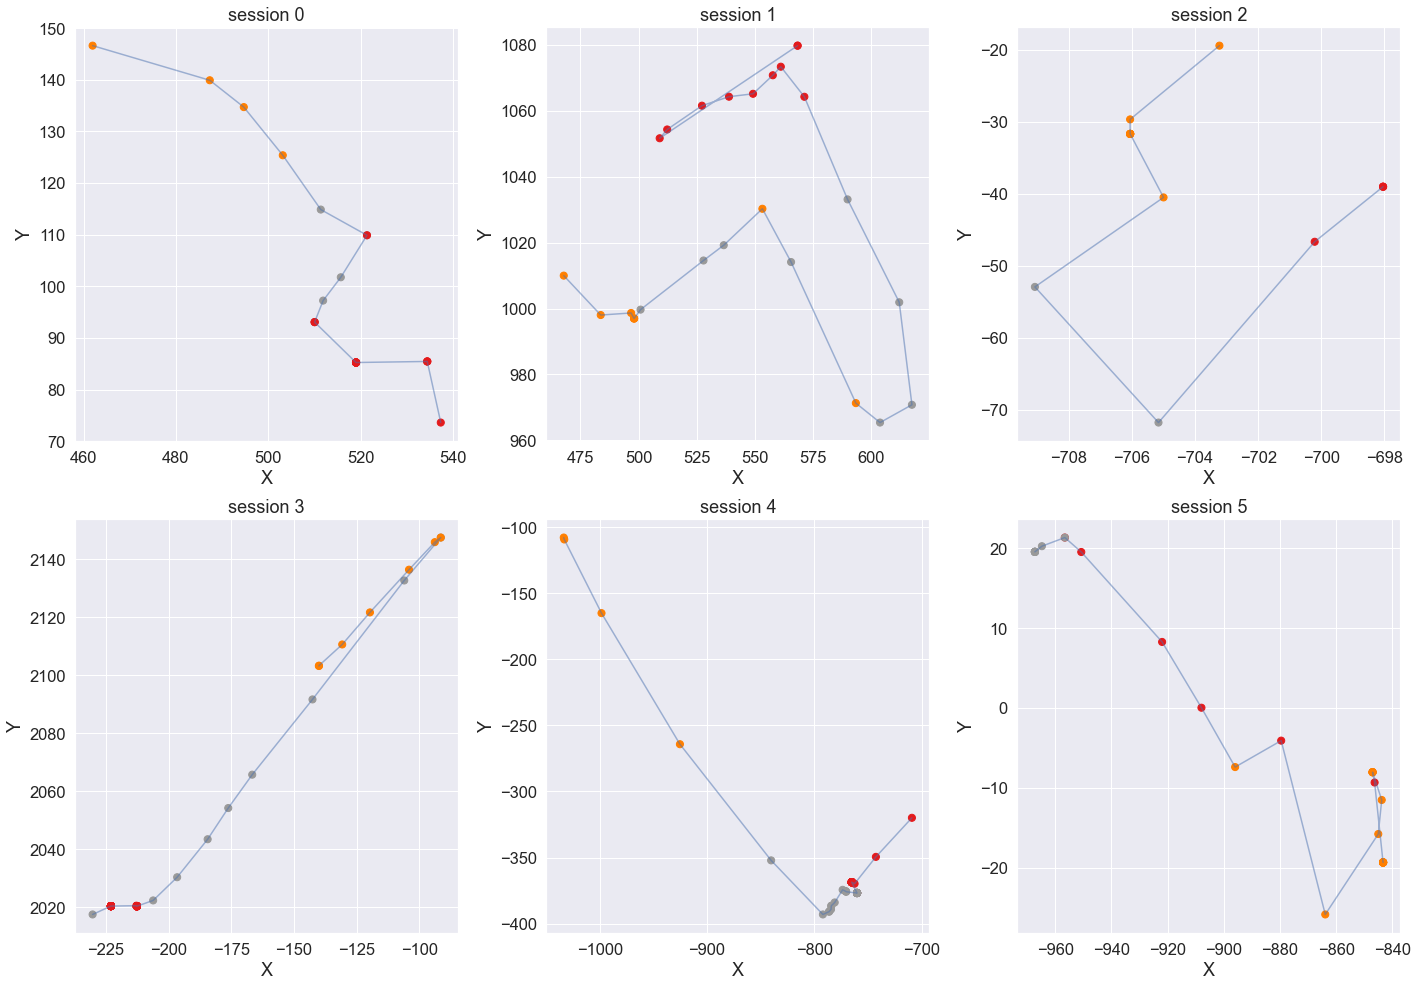

In [15]:
visualize_clustering(KMeans(n_clusters=3,
                            random_state=42,
                            n_init=100,
                            max_iter=1000).fit_predict)

Визуально, можно видеть, что во многих случаях алгоритм правильно кластеризовал рассмотренные точки сессии.


Попробуем теперь использовать другие, менее тривиальные алгоритмы кластеризации.

Например, аггломеративная кластеризация.

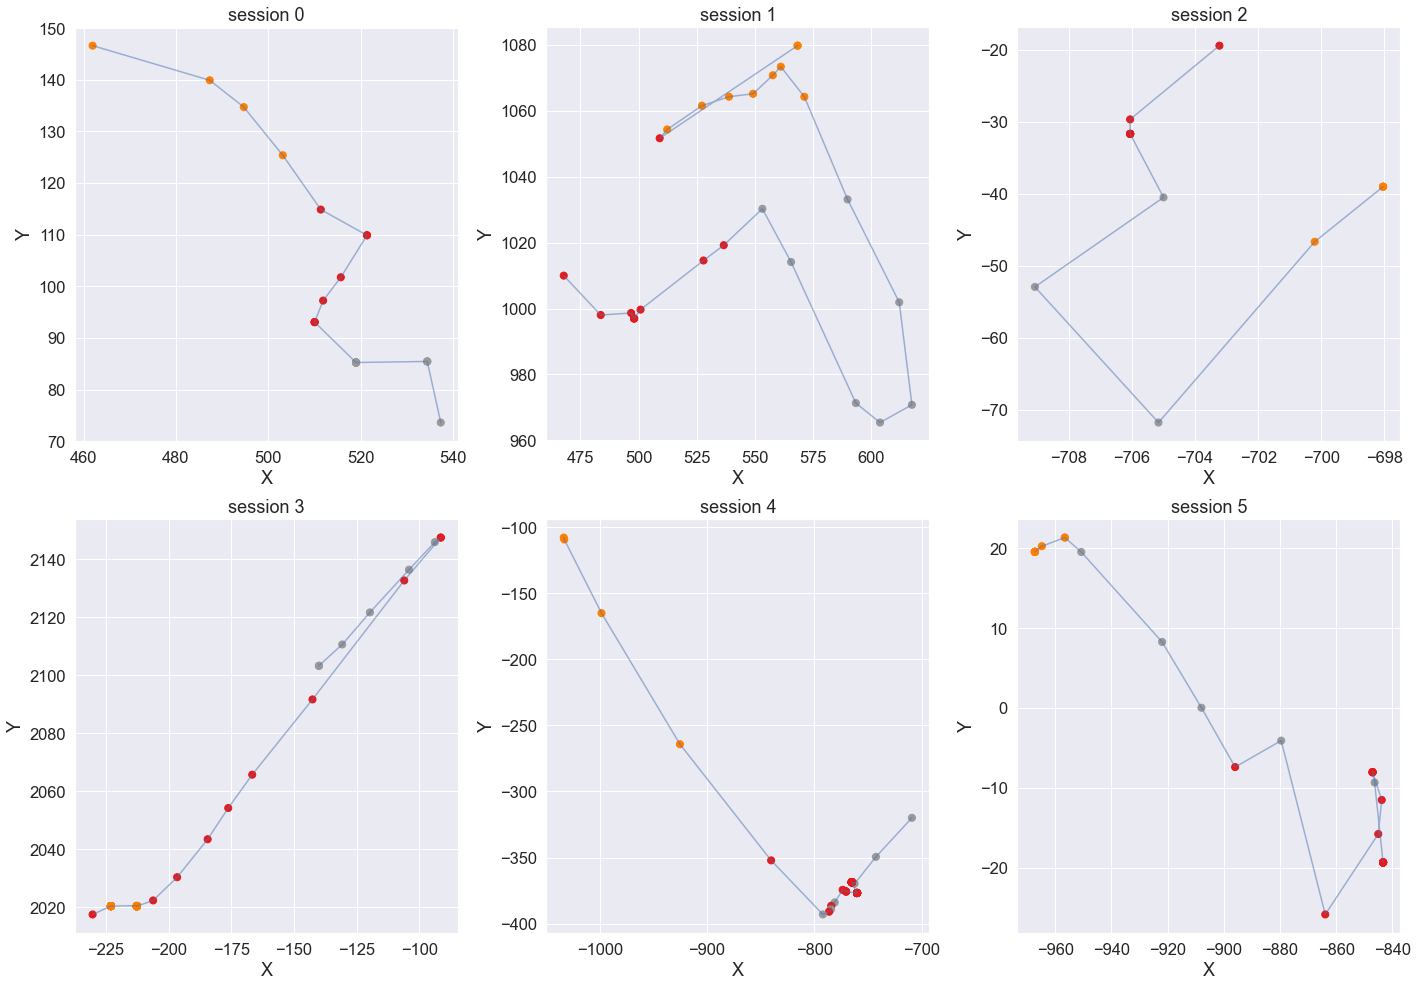

In [16]:
visualize_clustering(AgglomerativeClustering(n_clusters=3,
                                             linkage='ward').fit_predict)

Для метода спектральной кластеризации.

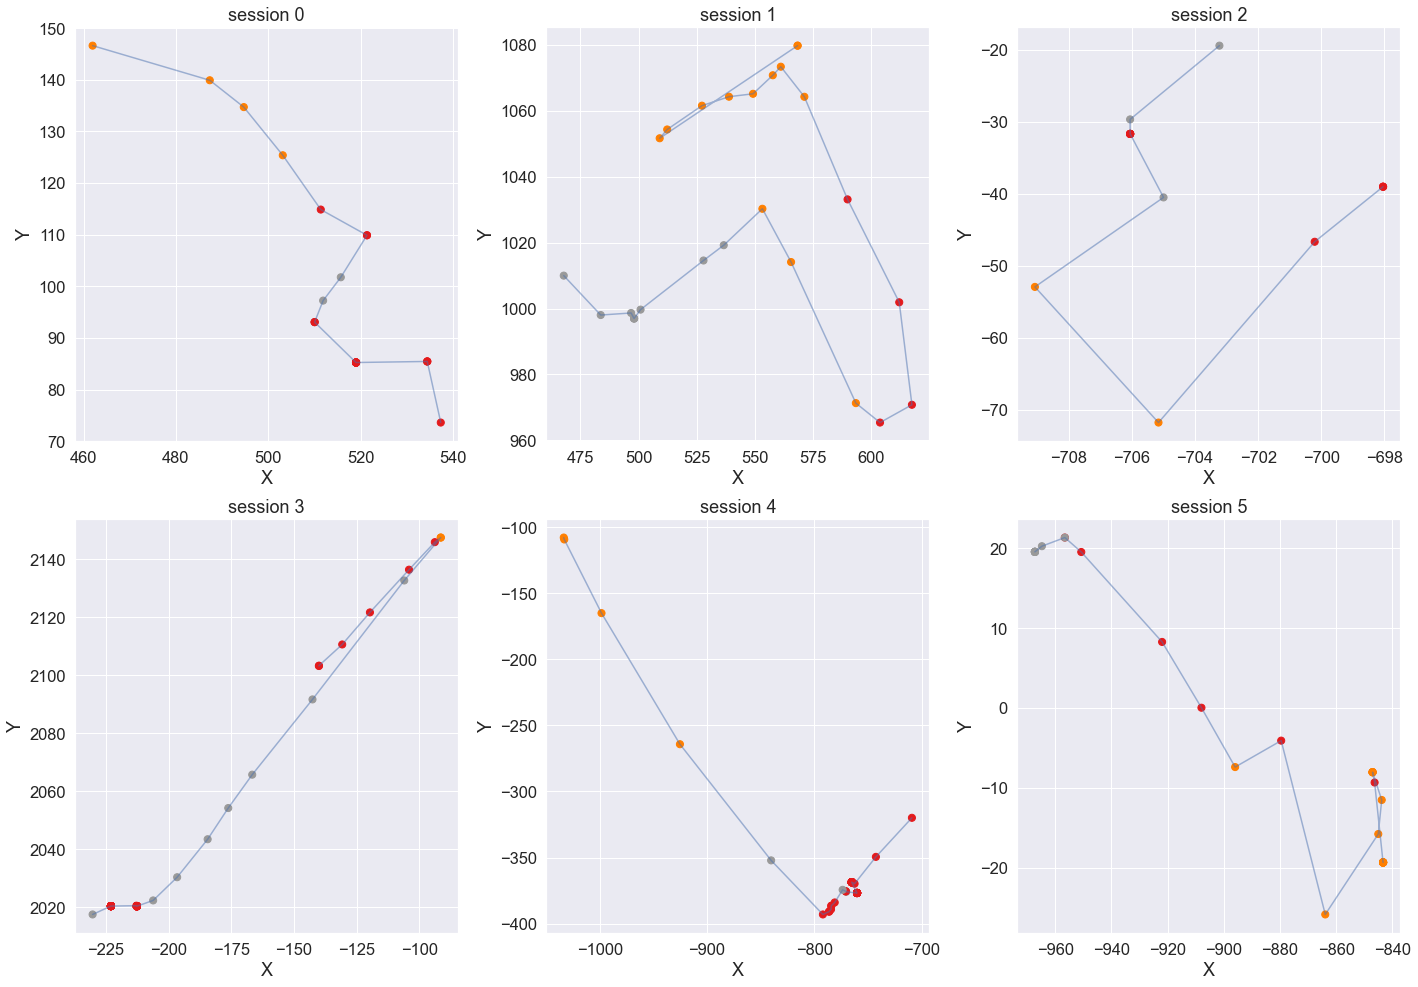

In [17]:
visualize_clustering(SpectralClustering(n_clusters=3).fit_predict)

В каждом случае алгоритмы разные алгоритмы кластеризации по-разному сработали на предложенных данных.

В качестве одного из способов нахождения точки посадки логично использовать последнюю точку (с точки зрения времени) кластера, отвечающего за ожидание (среднего кластера). Т.к. разные алгориитмы в разных случаях дали хорошие результаты, то усредним найденный ответ (по обеим координатам для трёх рассмотренных алгоритмов).

***Замечание*** 

В любом случае, будут сессии, которые кластеризовать не получится.

Будем добавлять признак кластера только для тех сессий, в которых среднее расстояние между точками "среднего" кластера не превосходят некоторого порога.

Чтобы подобрать порог, посмотрим на рапределение расстояний между точками "среднего" кластера.

In [18]:
def clustering_prediction(fit_predict_methods):
    session_values = np.unique(data.session.values)

    session_predictions = []
    cluster_distances = []
    for i, session in tqdm_notebook(enumerate(session_values), total=len(session_values)):
        
        # Данные рассматриваемой сессии
        session_data = data[data.session == session]
        session_data = session_data[session_data.ts != 0]
        
        columns = ['x', 'y', 'ts', 'av_speed', 'angle', 'dist']

        # Выделяем из данных сессии данные с нужными статусами
        status_1_data = session_data[session_data.status == 1].loc[:, columns].copy()
        status_0_data = session_data[session_data.status == 0].loc[:, columns].copy()
        status_2_data = session_data[session_data.status == 2].loc[:, columns].copy()
        
        # Соединяем всё вместе
        status_data_w_dist = pd.concat([status_0_data.iloc[-2:, :],
                                 status_1_data,
                                 status_2_data.iloc[:2, :]],
                                 axis=0)

        status_data = status_data_w_dist.loc[:, columns[:-1]].copy()
        
        #Стандартизуем данные
        scaler = StandardScaler(with_mean=False)
        status_data.iloc[:, :] = scaler.fit_transform(status_data.copy())
        
        x_preds = []
        y_preds = []
        dist_preds = []
        for method in fit_predict_methods:
            pred = method(status_data)
            
            # Найдём точки, где сменяется кластер
            candidates = []
            for j in range(len(pred) - 1):
                if pred[j] != pred[j+1]:
                    candidates.append(j)
            
            # Если кластера всего два, то возьмём последнюю рассматриваемую
            # точку в качестве правой границы
            if len(candidates) == 1:
                candidates.append(len(pred) - 1)
            
            # Предсказания и среднее расстояние в кластере
            x_preds.append(status_data_w_dist['x'].values[candidates[-1]])
            y_preds.append(status_data_w_dist['y'].values[candidates[-1]])
            dist_preds.append(np.mean(status_data_w_dist['dist'].values[candidates[0]:candidates[-1]+1]))
            
            
        x_pred = np.mean(x_preds)
        y_pred = np.mean(y_preds)
        
        session_predictions.append([i, x_pred, y_pred])
        cluster_distances.append(np.mean(dist_preds))
        
    return session_predictions, cluster_distances

fit_predict_methods = [KMeans(n_clusters=3,
                            random_state=42,
                            n_init=100,
                            max_iter=1000,
                            n_jobs=-1).fit_predict,
                       AgglomerativeClustering(n_clusters=3,
                                               linkage='ward').fit_predict,
                       SpectralClustering(n_clusters=3, n_jobs=-1).fit_predict]
                       
                       
predictions, cluster_distances = clustering_prediction(fit_predict_methods)

In [19]:
cluster_distances = np.array(cluster_distances)

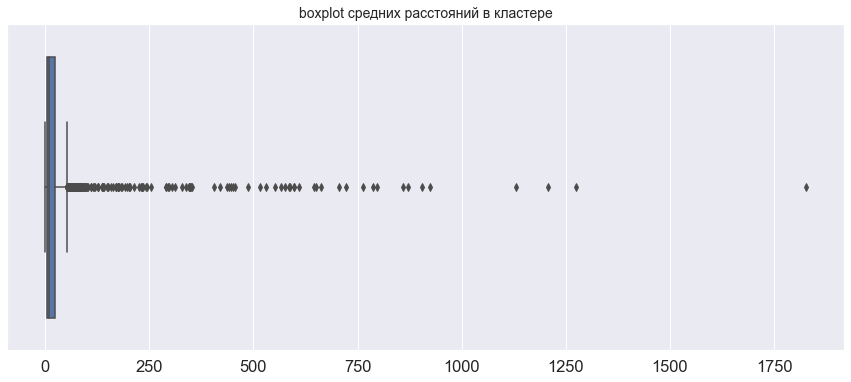

In [20]:
plt.figure(figsize=(15, 6))
plt.title('boxplot средних расстояний в кластере',
          fontsize=14)
sns.boxplot(cluster_distances)
plt.show()

Уберём слишком большие расстояния и нулевые значения.

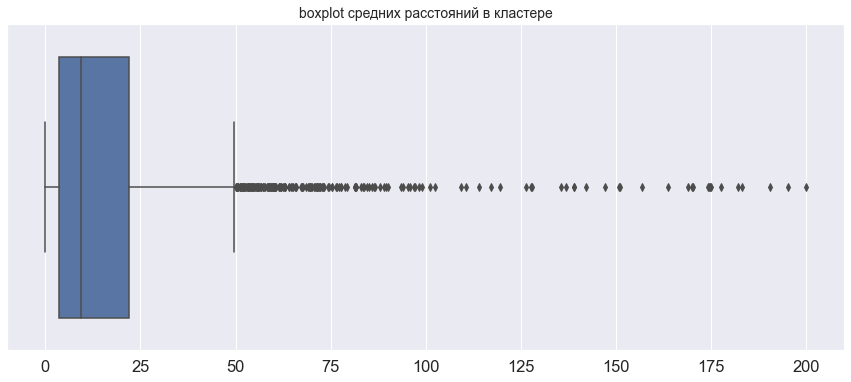

In [21]:
clean_cluster_distances = cluster_distances[cluster_distances < 200]
clean_cluster_distances = clean_cluster_distances[clean_cluster_distances != 0.0]

plt.figure(figsize=(15, 6))
plt.title('boxplot средних расстояний в кластере',
          fontsize=14)
sns.boxplot(clean_cluster_distances)
plt.show()

По ящику с усами сделаем вывод, что в качестве порога стоит взять значение 50.

Предсказания для сессий, которые удовлетворяют найденным требованиям.

In [25]:
predictions = np.array(predictions)

border = 50
valid_predictions = predictions[cluster_distances < border]

In [26]:
valid_predictions

array([[ 0.00000000e+00,  5.10017269e+02,  9.30667056e+01],
       [ 1.00000000e+00,  5.35756838e+02,  1.02008594e+03],
       [ 2.00000000e+00, -7.05152838e+02, -7.18097034e+01],
       ...,
       [ 2.99600000e+03,  5.77368044e+02, -3.90836663e+02],
       [ 2.99700000e+03,  4.18607354e+02, -1.03685689e+03],
       [ 2.99900000e+03,  4.69970686e+02,  3.37197706e+02]])

### 2. Создание датасета статистик по сессиям и поиск в нем кластерной структуры

Чтобы дальше предлагать решения с разбором случаев, в зависимости от того, как выглядит сессия, с которой мы работаем, попробуем сделать дасатет для сессий, а затем визуализировать его методами понижения размерности PCA, t-SNE, UMAP. Возможно, получится найти в нем кластерную структуру.

Для каждой сессии будем в качестве признаков брать общее кол-во точек в ней, кол-во точек в зависимости от статуса, среднюю скорость в зависимости от статуса, суммарное время для каждого статуса, суммарное расстояние для каждого статуса, а также направление движения, скорость, время и расстояние в точках перехода от одного статуса к другому.

In [27]:
def session_df(data):
    session_features = []
    
    session_values = np.unique(data.session.values)
    for session in tqdm_notebook(session_values):
        session_data = data[data.session == session].fillna(0)
        session_data = session_data.replace([np.inf, -np.inf], 0.)
    
        total_points = session_data.shape[0]
        st0_points = session_data[session_data.status == 0].shape[0] 
        st1_points = session_data[session_data.status == 1].shape[0]
        st2_points = session_data[session_data.status == 2].shape[0]
        
        speed = session_data.av_speed.values.mean()
        st0_speed = session_data[session_data.status == 0].av_speed.values.mean()
        st1_speed = session_data[session_data.status == 1].av_speed.values.mean()
        st2_speed = session_data[session_data.status == 2].av_speed.values.mean()
        
        time = session_data.ts.values.sum()
        st0_time = session_data[session_data.status == 0].ts.values.sum()
        st1_time = session_data[session_data.status == 1].ts.values.sum()
        st2_time = session_data[session_data.status == 2].ts.values.sum()
        
        dist = session_data.dist.values.sum()
        st0_dist = session_data[session_data.status == 0].dist.values.sum()
        st1_dist = session_data[session_data.status == 1].dist.values.sum()
        st2_dist = session_data[session_data.status == 2].dist.values.sum()
        
        st01_dist = session_data[session_data.status == 1].head(1).dist.values[0]
        st12_dist = session_data[session_data.status == 2].head(1).dist.values[0]
        
        st01_angle = session_data[session_data.status == 1].head(1).angle.values[0]
        st12_angle = session_data[session_data.status == 2].head(1).angle.values[0]
        
        st01_speed = session_data[session_data.status == 1].head(1).av_speed.values[0]
        st12_speed = session_data[session_data.status == 2].head(1).av_speed.values[0]
        
        st01_time = session_data[session_data.status == 1].head(1).ts.values[0]
        st12_time = session_data[session_data.status == 2].head(1).ts.values[0]
        
        features_list = [session, total_points, st0_points, st1_points, st2_points,
                         speed, st0_speed, st1_speed, st2_speed,
                         time, st0_time, st1_time, st2_time,
                         dist, st0_dist, st1_dist, st2_dist,
                         st01_dist, st12_dist, st01_angle, st12_angle, 
                         st01_speed, st12_speed, st01_time, st12_time]
        
        session_features.append(features_list)
        
    df = pd.DataFrame(session_features, 
                      columns=['session', 'total_points', 'st0_points',
                               'st1_points', 'st2_points', 'speed',
                               'st0_speed', 'st1_speed', 'st2_speed',
                               'time', 'st0_time', 'st1_time', 'st2_time',
                               'dist', 'st0_dist', 'st1_dist', 'st2_dist',
                               'st01_dist', 'st12_dist', 'st01_angle', 'st12_angle',
                               'st01_speed', 'st12_speed', 'st01_time', 'st12_time'])
    return df

In [28]:
sessions = session_df(data)

In [29]:
sessions.head()

,session,total_points,st0_points,st1_points,st2_points,speed,st0_speed,st1_speed,st2_speed,time,...,st1_dist,st2_dist,st01_dist,st12_dist,st01_angle,st12_angle,st01_speed,st12_speed,st01_time,st12_time
0,0,115,39,26,50,3.911848,2.240553,1.150516,6.651351,49244,...,120.056558,2923.145938,26.231530,12.192180,-0.258458,-1.328303,2.914614,1.016015,287,471
1,1,105,46,24,35,4.534931,4.271744,2.100467,6.550180,49976,...,420.786586,1780.789538,0.000000,19.889163,0.000000,2.495906,0.000000,2.486145,319,692
2,2,72,17,13,42,4.994178,6.188842,1.225115,5.677239,17815,...,87.418396,1835.778632,10.630688,0.000000,-1.839990,0.000000,3.543563,0.000000,125,211
3,3,178,50,78,50,4.446038,6.626549,0.451911,8.496363,119631,...,260.678963,3395.911886,7.857176,0.125438,0.375982,-1.826738,1.122454,0.062719,371,975
4,4,179,50,97,32,1.198554,2.465206,0.664298,0.838870,110841,...,501.527198,128.056280,44.742800,1.530157,-2.419576,1.890311,5.592850,0.255026,316,1051


In [30]:
sessions.shape

(3000, 25)

Размерность получилась не очень большая, поэтому PCA, t-SNE и UMAP должны здесь хорошо работать (при большой размерности, t-SNE, например, плох).

In [31]:
pca = PCA(n_components=2)

principalComponents = pca.fit_transform(np.array(sessions.fillna(0.)))
principalDf = pd.DataFrame(data = principalComponents,
                           columns = ['principal_component_1',
                                      'principal_component_2'])

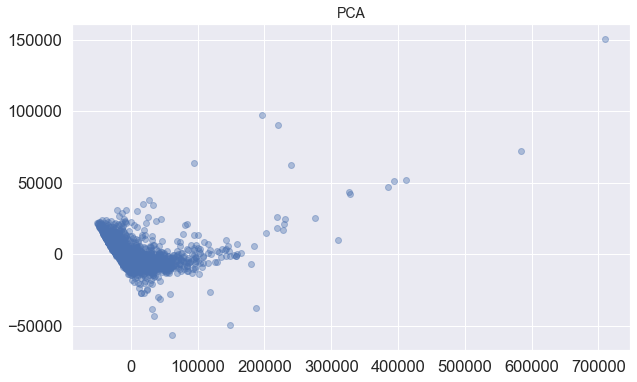

In [32]:
plt.figure(figsize=(10, 6))
plt.title('PCA', fontsize=14)
plt.scatter(principalDf.principal_component_1.values,
            principalDf.principal_component_2.values,
            alpha=0.4)
plt.show()

In [33]:
%%time

tsne = TSNE(n_components=2).fit_transform(np.array(sessions.fillna(0.)))

Wall time: 15.6 s


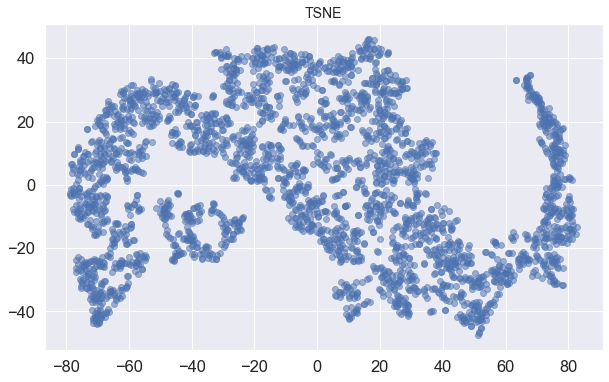

In [34]:
plt.figure(figsize=(10, 6))
plt.scatter(tsne[:, 0], tsne[:, 1], 
            alpha=0.5)
plt.title('TSNE', fontsize=14)
plt.show()

In [35]:
%%time 

umap = UMAP(n_components=2, 
            n_neighbors=15).fit_transform(np.array(sessions.fillna(0.)))

Wall time: 8.73 s


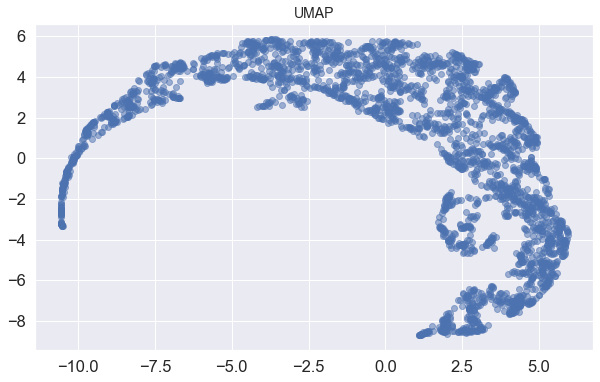

In [36]:
plt.figure(figsize=(10, 6))
plt.scatter(umap[:, 0], umap[:, 1], 
            alpha=0.5)
plt.title('UMAP', fontsize=14)
plt.show()

**Результаты:** PCA показал один кластер и выбросы. t-SNE и UMAP тоже отображают почти все сессии в одном кластере, но можно заметить небольшие "кучки" чуть отделенных от этого кластера сессий.

## Глава 3. Метрика

### 1. Описание

**Идейно:**

Итак, поездки можно разделить на два типа:

1) Водитель вовремя включил статус 2.

2) Водитель опоздал с включением статуса 2. Тогда в статусе 1 есть набор точек, соответствующий "ожиданию" пассажира.

При этом случай (1) встречается гораздо чаще случая (2). Тогда логично в качестве метрики взять расстояние до первой (хронологически) точки со статусом 2 и применить некоторую регуляризацию: штрафовать метрику, если предсказанная точка слишком далеко от кластера "ожидания". 

**Формально:**

Пусть к точкам со статусом 1 сессии с номером i применили кластеризацию на 3 кластера. 

Пусть $a_i$ - последняя по времени точка среднего кластера (кластера ожидания).

Пусть $b_i$ - первая точка со статусом 2 в сессии.

Пусть $ans_i$ - предсказанная точка посадки пассажира для данной сессии.

Тогда возьмем в качестве метрики:

$$ f(a_i, b_i, ans_i) = \rho(ans_i, b_i) + \alpha \rho(ans_i, a_i)$$

Где $\alpha $ - некоторый параметр регуляризации, $\rho$ - евклидово расстояние.

Тогда оценка качества предсказаний для многих сессий:

$$ F(a, b, ans) = \frac{1}{N} \sum_{i=1}^N f(a_i, b_i, ans_i)$$

### 2. Имплементация

Создадим словарь для сессий: {номер сессии: [последняя точка в кластере ожидания, первая точка со статусом 2]}

In [44]:
eval_dict = {}

first_st2 = first_status_2(data)
for key, cluster_pred in zip(first_st2, predictions):
    cluster_point = (cluster_pred[1], cluster_pred[2])
    first2_point = first_st2[key]
    eval_dict[key] = [first2_point, cluster_point]

In [48]:
eval_df = pd.DataFrame.from_dict(eval_dict, orient='index',
                                 columns=['cluster_pred', 'first_status2'])

In [49]:
eval_df.head()

,cluster_pred,first_status2
0,"(537.3231537026003, 73.614186697968)","(510.01726854950516, 93.06670560779078)"
1,"(467.8795440394896, 1009.9926489507196)","(535.7568380773753, 1020.0859420321573)"
2,"(-698.0440558086012, -39.04076617575709)","(-705.1528376654356, -71.80970340073668)"
3,"(-140.0357842608851, 2103.199405836623)","(-157.7600129313474, 2078.231321268458)"
4,"(-1033.5182993279884, -107.76234118736177)","(-892.8976919687669, -289.7585470426346)"


Пусть preds - словарь предсказаний вида {номер сессии: точка посадки}

In [52]:
def dist(point1, point2):
    return np.sqrt((point1[0] - point2[0])**2 + \
                   (point1[1] - point2[1])**2)

def MyMetric(eval_dict, preds, alpha=0.1):
    copy_eval = eval_df.copy()
    metrics = []
    for key in eval_dict:
        a = eval_dict[key][0]
        b = eval_dict[key][1]
        metrics.append(alpha*dist(a, preds[key]) + \
                       dist(b, preds[key]))
        
    return metrics

### 3. Метрика для существуюших решений

**3.1)** Последняя точка со статусом 2

In [95]:
preds = first_status_2(data)
metrics = MyMetric(eval_dict, preds)

print(f'Значение метрики: {np.mean(metrics)}')


Значение метрики: 30.471034867592156


In [96]:
def plot_metrics(metrics):
    plt.figure(figsize=(10, 4))

    plt.subplot(121)
    plt.title('Гистограмма значений метрики')
    plt.hist(metrics, bins=10)

    plt.subplot(122)
    plt.title('Boxplot значений метрики')
    sns.boxplot(metrics)

    plt.show()

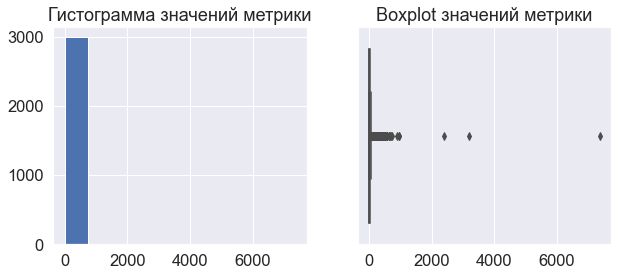

In [97]:
plot_metrics(metrics)

Как видим, получается очень много выбросов, посмотри на распределение метрики без них

In [98]:
q = np.quantile(metrics, q=0.95)
metrics = np.array(metrics)
metrics = metrics[np.where(metrics < q)[0]]
print(f'Значение после удаления выборосов: {np.mean(metrics)}')

Значение после удаления выборосов: 13.14584942756251


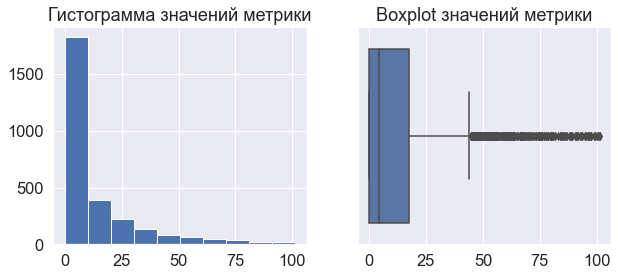

In [100]:
plot_metrics(metrics)

**3.2)** середина отрезка между точками со статусами 1 и 2 

In [101]:
preds = middle_1_2(data)
metrics = MyMetric(eval_dict, preds)

print(f'Значение метрики: {np.mean(metrics)}')


Значение метрики: 26.96261184315724


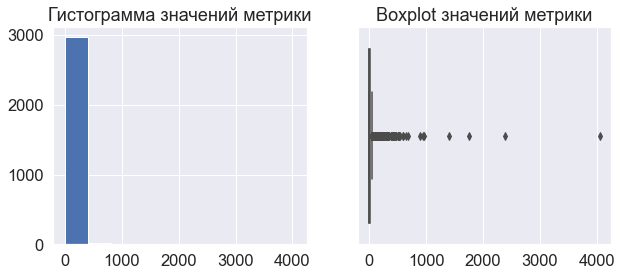

In [102]:
plot_metrics(metrics)

Снова много выбросов.

Значение после удаления выборосов: 12.018711285407644


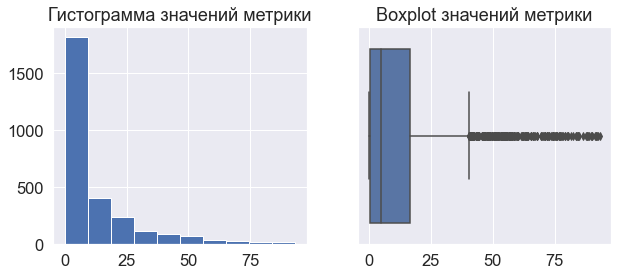

In [103]:
q = np.quantile(metrics, q=0.95)
metrics = np.array(metrics)
metrics = metrics[np.where(metrics < q)[0]]
print(f'Значение после удаления выборосов: {np.mean(metrics)}')

plot_metrics(metrics)

**Результат:** значение получилось меньше, чем если всегда брать точку со статусом 2.  

**3.3)** статус 1, если статус 2 далеко, иначе статус 2

In [104]:
preds = distance_1_2(data)
metrics = MyMetric(eval_dict, preds)

print(f'Значение метрики: {np.mean(metrics)}')


Значение метрики: 25.131300844831305


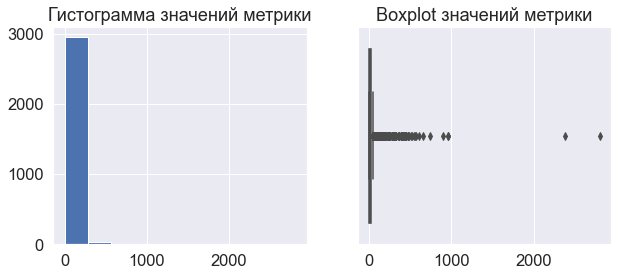

In [105]:
plot_metrics(metrics)

Значение после удаления выборосов: 11.84069061020883


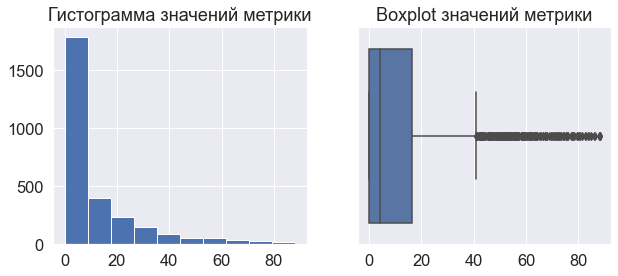

In [106]:
q = np.quantile(metrics, q=0.95)
metrics = np.array(metrics)
metrics = metrics[np.where(metrics < q)[0]]
print(f'Значение после удаления выборосов: {np.mean(metrics)}')

plot_metrics(metrics)

**Результат:** Для данного решения получилось много выбросов, но после их удаления решение выдало лучшее значение метрики, чем два других рассмотренных ранее. 

**3.4)** последняя точка в кластере ожидания, если расстояние между точками этого кластера меньше некоторого порога, иначе первая точка со статусом 2.

In [119]:
preds = {}
for pred in valid_predictions:
    preds[int(pred[0])] = (pred[1], pred[2])
    
first2 = first_status_2(data)

for key in first2:
    if key not in preds:
        preds[key] = first2[key]
        
metrics = MyMetric(eval_dict, preds)

print(f'Значение метрики: {np.mean(metrics)}')


Значение метрики: 8.03746068399398


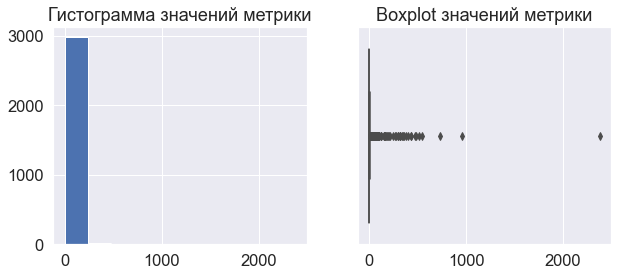

In [120]:
plot_metrics(metrics)

Значение после удаления выборосов: 1.85596380716079


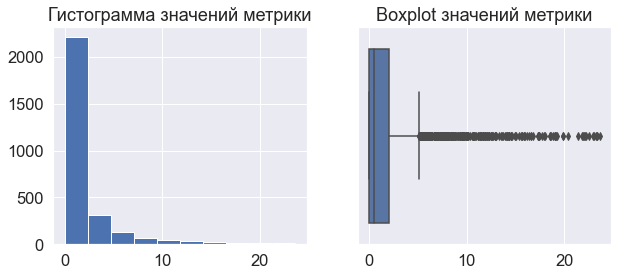

In [121]:
q = np.quantile(metrics, q=0.95)
metrics = np.array(metrics)
metrics = metrics[np.where(metrics < q)[0]]
print(f'Значение после удаления выборосов: {np.mean(metrics)}')

plot_metrics(metrics)

**Результат:** это решение оказалось наилучшим

### 4. Параметр регуляризации

Возьмем наилучшее решение, посмотрим как значение метрики будет меняться в зависимости от регуляризации

In [124]:
alphas = np.linspace(0.01, 1., 1000)

metrics = []
for alpha in alphas:
    metrics.append(np.mean(MyMetric(eval_dict, preds, alpha=alpha))) 

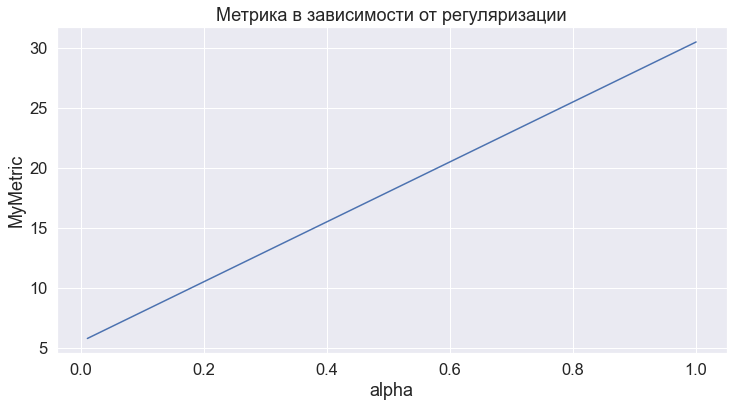

In [126]:
plt.figure(figsize=(12, 6))
plt.title('Метрика в зависимости от регуляризации')
plt.plot(alphas, metrics)
plt.xlabel('alpha')
plt.ylabel('MyMetric')
plt.show()

**Результат:** так как мы в большинстве случае предсказываем последнюю точку из кластера ожидания, то с ростом штрафа за отдаление от этого кластера растет и значение метрики. 